In [1]:
import numpy as np
from matplotlib import pyplot as plt
import re
import os
import random
import pandas as pd
import tensorflow as tf
import keras
import glob
import cv2
import numpy as np
from random import shuffle
from tqdm import tqdm
from tensorflow.python.framework import graph_util
from keras.layers import *
from keras.optimizers import *
import sys
import pandas as pd
import pickle
import time
from keras.models import Model, Sequential
from keras.regularizers import l2
from keras import backend as K
from keras.optimizers import Adam
from skimage.io import imshow
from keras.layers.normalization import BatchNormalization
from keras.initializers import glorot_uniform
from keras.engine.topology import Layer
from sklearn.utils import shuffle
import numpy.random as rng
from keras.utils import to_categorical
from keras.utils import np_utils
from keras.utils import to_categorical
from keras.models import Model, load_model
from keras.preprocessing.image import ImageDataGenerator, load_img, img_to_array, array_to_img
from sklearn.model_selection import train_test_split
from functools import partial, update_wrapper
import pydot
#install pip pydot_ng
from keras import backend as K
from keras.models import Model
from keras.layers import Input
from keras.layers import Dense
from keras.layers import Conv2D
from keras.layers import Lambda
from keras.layers import Flatten
from keras.layers import Reshape
from keras.layers import Dropout
from keras.layers import Activation
from keras.layers import AveragePooling2D
from keras.layers import BatchNormalization
from keras.layers.merge import add, concatenate
from keras.preprocessing.image import ImageDataGenerator
from keras.utils import plot_model
import pydot
#install pip pydot_ng
import pydot_ng as pydot
print (pydot.find_graphviz())
np.random.seed(42)
%matplotlib inline
plt.rcParams['image.cmap'] = 'gray'

Using TensorFlow backend.


{'dot': 'C:\\Program Files\\Graphviz 2.44.1\\bin\\dot.exe', 'twopi': '', 'neato': '', 'circo': '', 'fdp': '', 'sfdp': ''}


In [2]:
#print("tf.version is", tf.version)
#print("tf.keras.version is:", tf.keras.version)

def _get_available_gpus():
    """Get a list of available gpu devices (formatted as strings).

    # Returns
        A list of available GPU devices.
    """
    #global _LOCAL_DEVICES
    if tfback._LOCAL_DEVICES is None:
        devices = tf.config.list_logical_devices()
        tfback._LOCAL_DEVICES = [x.name for x in devices]
    return [x for x in tfback._LOCAL_DEVICES if 'device:gpu' in x.lower()]

#tfback._get_available_gpus = _get_available_gpus
#tfback._get_available_gpus()
#tf.config.list_logical_devices()

In [3]:

DIMEN = 224

X1 = np.load( 'processed_data/x1.npy')
X2 = np.load( 'processed_data/x2.npy')
Y = np.load( 'processed_data/y.npy')

X1 = X1.reshape( ( X1.shape[0]  , DIMEN**2 * 3  ) ).astype( np.float32 )
X2 = X2.reshape( ( X2.shape[0]  , DIMEN**2 * 3  ) ).astype( np.float32 )

train_X1 = X1[ : 4500 ] 
train_X2 = X2[ : 4500 ] 
train_Y = Y[ : 4500 ] 

test_X1 = X1[ 4500 : ]
test_X2 = X2[ 4500 : ] 
test_Y = Y[ 4500 : ]
 
print(  train_X1.shape )
print(  train_X2.shape )
print(  train_Y.shape )

print(test_X1.shape )
print(test_X2.shape )
print(test_Y.shape) 


(4500, 150528)
(4500, 150528)
(4500, 1)
(541, 150528)
(541, 150528)
(541, 1)


# ValueError: Error when checking input: expected input_3 to have 4 dimensions, but got array with shape (4500, 150528)
1. in order to avoid running into the above error, kindly reshape the inputs data into 4 dimensions i.e (4500, 224, 224, 3)

In [4]:
train_X1 = train_X1.reshape(-1,224, 224, 3)   #Reshape for CNN -  should work!!
train_X2 = train_X2.reshape(-1,224, 224, 3)

test_X1 = test_X1.reshape(-1,224, 224, 3)
test_X2 = test_X2.reshape(-1,224, 224, 3)


In [5]:
print(  train_X1.shape )
print(  train_X2.shape )
print(  train_Y.shape )

print(test_X1.shape )
print(test_X2.shape )
print(test_Y.shape) 

(4500, 224, 224, 3)
(4500, 224, 224, 3)
(4500, 1)
(541, 224, 224, 3)
(541, 224, 224, 3)
(541, 1)


In [6]:
input_shape = (224, 224, 3)

In [7]:
# batch operation usng tensor slice
def WaveletTransformAxisY(batch_img):
    odd_img  = batch_img[:,0::2]
    even_img = batch_img[:,1::2]
    L = (odd_img + even_img) / 2.0
    H = K.abs(odd_img - even_img)
    return L, H

def WaveletTransformAxisX(batch_img):
    # transpose + fliplr
    tmp_batch = K.permute_dimensions(batch_img, [0, 2, 1])[:,:,::-1]
    _dst_L, _dst_H = WaveletTransformAxisY(tmp_batch)
    # transpose + flipud
    dst_L = K.permute_dimensions(_dst_L, [0, 2, 1])[:,::-1,...]
    dst_H = K.permute_dimensions(_dst_H, [0, 2, 1])[:,::-1,...]
    return dst_L, dst_H

In [8]:
def Wavelet(batch_image):
    # make channel first image
    batch_image = K.permute_dimensions(batch_image, [0, 3, 1, 2])
    r = batch_image[:,0]
    g = batch_image[:,1]
    b = batch_image[:,2]

    # level 1 decomposition
    wavelet_L, wavelet_H = WaveletTransformAxisY(r)
    r_wavelet_LL, r_wavelet_LH = WaveletTransformAxisX(wavelet_L)
    r_wavelet_HL, r_wavelet_HH = WaveletTransformAxisX(wavelet_H)

    wavelet_L, wavelet_H = WaveletTransformAxisY(g)
    g_wavelet_LL, g_wavelet_LH = WaveletTransformAxisX(wavelet_L)
    g_wavelet_HL, g_wavelet_HH = WaveletTransformAxisX(wavelet_H)

    wavelet_L, wavelet_H = WaveletTransformAxisY(b)
    b_wavelet_LL, b_wavelet_LH = WaveletTransformAxisX(wavelet_L)
    b_wavelet_HL, b_wavelet_HH = WaveletTransformAxisX(wavelet_H)

    wavelet_data = [r_wavelet_LL, r_wavelet_LH, r_wavelet_HL, r_wavelet_HH, 
                    g_wavelet_LL, g_wavelet_LH, g_wavelet_HL, g_wavelet_HH,
                    b_wavelet_LL, b_wavelet_LH, b_wavelet_HL, b_wavelet_HH]
    transform_batch = K.stack(wavelet_data, axis=1)

    # level 2 decomposition
    wavelet_L2, wavelet_H2 = WaveletTransformAxisY(r_wavelet_LL)
    r_wavelet_LL2, r_wavelet_LH2 = WaveletTransformAxisX(wavelet_L2)
    r_wavelet_HL2, r_wavelet_HH2 = WaveletTransformAxisX(wavelet_H2)

    wavelet_L2, wavelet_H2 = WaveletTransformAxisY(g_wavelet_LL)
    g_wavelet_LL2, g_wavelet_LH2 = WaveletTransformAxisX(wavelet_L2)
    g_wavelet_HL2, g_wavelet_HH2 = WaveletTransformAxisX(wavelet_H2)

    wavelet_L2, wavelet_H2 = WaveletTransformAxisY(b_wavelet_LL)
    b_wavelet_LL2, b_wavelet_LH2 = WaveletTransformAxisX(wavelet_L2)
    b_wavelet_HL2, b_wavelet_HH2 = WaveletTransformAxisX(wavelet_H2)


    wavelet_data_l2 = [r_wavelet_LL2, r_wavelet_LH2, r_wavelet_HL2, r_wavelet_HH2, 
                    g_wavelet_LL2, g_wavelet_LH2, g_wavelet_HL2, g_wavelet_HH2,
                    b_wavelet_LL2, b_wavelet_LH2, b_wavelet_HL2, b_wavelet_HH2]
    transform_batch_l2 = K.stack(wavelet_data_l2, axis=1)

    # level 3 decomposition
    wavelet_L3, wavelet_H3 = WaveletTransformAxisY(r_wavelet_LL2)
    r_wavelet_LL3, r_wavelet_LH3 = WaveletTransformAxisX(wavelet_L3)
    r_wavelet_HL3, r_wavelet_HH3 = WaveletTransformAxisX(wavelet_H3)

    wavelet_L3, wavelet_H3 = WaveletTransformAxisY(g_wavelet_LL2)
    g_wavelet_LL3, g_wavelet_LH3 = WaveletTransformAxisX(wavelet_L3)
    g_wavelet_HL3, g_wavelet_HH3 = WaveletTransformAxisX(wavelet_H3)

    wavelet_L3, wavelet_H3 = WaveletTransformAxisY(b_wavelet_LL2)
    b_wavelet_LL3, b_wavelet_LH3 = WaveletTransformAxisX(wavelet_L3)
    b_wavelet_HL3, b_wavelet_HH3 = WaveletTransformAxisX(wavelet_H3)

    wavelet_data_l3 = [r_wavelet_LL3, r_wavelet_LH3, r_wavelet_HL3, r_wavelet_HH3, 
                    g_wavelet_LL3, g_wavelet_LH3, g_wavelet_HL3, g_wavelet_HH3,
                    b_wavelet_LL3, b_wavelet_LH3, b_wavelet_HL3, b_wavelet_HH3]
    transform_batch_l3 = K.stack(wavelet_data_l3, axis=1)

    # level 4 decomposition
    wavelet_L4, wavelet_H4 = WaveletTransformAxisY(r_wavelet_LL3)
    r_wavelet_LL4, r_wavelet_LH4 = WaveletTransformAxisX(wavelet_L4)
    r_wavelet_HL4, r_wavelet_HH4 = WaveletTransformAxisX(wavelet_H4)

    wavelet_L4, wavelet_H4 = WaveletTransformAxisY(g_wavelet_LL3)
    g_wavelet_LL4, g_wavelet_LH4 = WaveletTransformAxisX(wavelet_L4)
    g_wavelet_HL4, g_wavelet_HH4 = WaveletTransformAxisX(wavelet_H4)

    wavelet_L3, wavelet_H3 = WaveletTransformAxisY(b_wavelet_LL3)
    b_wavelet_LL4, b_wavelet_LH4 = WaveletTransformAxisX(wavelet_L4)
    b_wavelet_HL4, b_wavelet_HH4 = WaveletTransformAxisX(wavelet_H4)


    wavelet_data_l4 = [r_wavelet_LL4, r_wavelet_LH4, r_wavelet_HL4, r_wavelet_HH4, 
                    g_wavelet_LL4, g_wavelet_LH4, g_wavelet_HL4, g_wavelet_HH4,
                    b_wavelet_LL4, b_wavelet_LH4, b_wavelet_HL4, b_wavelet_HH4]
    transform_batch_l4 = K.stack(wavelet_data_l4, axis=1)

    # print('shape before')
    # print(transform_batch.shape)
    # print(transform_batch_l2.shape)
    # print(transform_batch_l3.shape)
    # print(transform_batch_l4.shape)

    decom_level_1 = K.permute_dimensions(transform_batch, [0, 2, 3, 1])
    decom_level_2 = K.permute_dimensions(transform_batch_l2, [0, 2, 3, 1])
    decom_level_3 = K.permute_dimensions(transform_batch_l3, [0, 2, 3, 1])
    decom_level_4 = K.permute_dimensions(transform_batch_l4, [0, 2, 3, 1])
    
    # print('shape after')
    # print(decom_level_1.shape)
    # print(decom_level_2.shape)
    # print(decom_level_3.shape)
    # print(decom_level_4.shape)
    return [decom_level_1, decom_level_2, decom_level_3, decom_level_4]


def Wavelet_out_shape(input_shapes):
    # print('in to shape')
    return [tuple([None, 112, 112, 12]), tuple([None, 56, 56, 12]), 
            tuple([None, 28, 28, 12]), tuple([None, 14, 14, 12])]

In [9]:
img_batch = K.zeros(shape=(8, 224, 224, 3), dtype='float32')
Wavelet(img_batch)


[<tf.Tensor 'transpose_73:0' shape=(8, 112, 112, 12) dtype=float32>,
 <tf.Tensor 'transpose_74:0' shape=(8, 56, 56, 12) dtype=float32>,
 <tf.Tensor 'transpose_75:0' shape=(8, 28, 28, 12) dtype=float32>,
 <tf.Tensor 'transpose_76:0' shape=(8, 14, 14, 12) dtype=float32>]

In [10]:
def get_wavelet_cnn_model():

    input_shape = 224, 224, 3

    input_ = Input(input_shape, name='the_input')
    # wavelet = Lambda(Wavelet, name='wavelet')
    wavelet = Lambda(Wavelet, Wavelet_out_shape, name='wavelet')
    input_l1, input_l2, input_l3, input_l4 = wavelet(input_)
    # print(input_l1)
    # print(input_l2)
    # print(input_l3)
    # print(input_l4)
    # level one decomposition starts
    conv_1 = Conv2D(64, kernel_size=(3, 3), padding='same', name='conv_1')(input_l1)
    norm_1 = BatchNormalization(name='norm_1')(conv_1)
    relu_1 = Activation('relu', name='relu_1')(norm_1)

    conv_1_2 = Conv2D(64, kernel_size=(3, 3), strides=(2, 2), padding='same', name='conv_1_2')(relu_1)
    norm_1_2 = BatchNormalization(name='norm_1_2')(conv_1_2)
    relu_1_2 = Activation('relu', name='relu_1_2')(norm_1_2)

    # level two decomposition starts
    conv_a = Conv2D(filters=64, kernel_size=(3, 3), padding='same', name='conv_a')(input_l2)
    norm_a = BatchNormalization(name='norm_a')(conv_a)
    relu_a = Activation('relu', name='relu_a')(norm_a)

    # concate level one and level two decomposition
    concate_level_2 = concatenate([relu_1_2, relu_a])
    conv_2 = Conv2D(128, kernel_size=(3, 3), padding='same', name='conv_2')(concate_level_2)
    norm_2 = BatchNormalization(name='norm_2')(conv_2)
    relu_2 = Activation('relu', name='relu_2')(norm_2)

    conv_2_2 = Conv2D(128, kernel_size=(3, 3), strides=(2, 2), padding='same', name='conv_2_2')(relu_2)
    norm_2_2 = BatchNormalization(name='norm_2_2')(conv_2_2)
    relu_2_2 = Activation('relu', name='relu_2_2')(norm_2_2)

    # level three decomposition starts 
    conv_b = Conv2D(filters=64, kernel_size=(3, 3), padding='same', name='conv_b')(input_l3)
    norm_b = BatchNormalization(name='norm_b')(conv_b)
    relu_b = Activation('relu', name='relu_b')(norm_b)

    conv_b_2 = Conv2D(128, kernel_size=(3, 3), padding='same', name='conv_b_2')(relu_b)
    norm_b_2 = BatchNormalization(name='norm_b_2')(conv_b_2)
    relu_b_2 = Activation('relu', name='relu_b_2')(norm_b_2)

    # concate level two and level three decomposition 
    concate_level_3 = concatenate([relu_2_2, relu_b_2])
    conv_3 = Conv2D(256, kernel_size=(3, 3), padding='same', name='conv_3')(concate_level_3)
    norm_3 = BatchNormalization(name='nomr_3')(conv_3)
    relu_3 = Activation('relu', name='relu_3')(norm_3)

    conv_3_2 = Conv2D(256, kernel_size=(3, 3), strides=(2, 2), padding='same', name='conv_3_2')(relu_3)
    norm_3_2 = BatchNormalization(name='norm_3_2')(conv_3_2)
    relu_3_2 = Activation('relu', name='relu_3_2')(norm_3_2)

    # level four decomposition start
    conv_c = Conv2D(64, kernel_size=(3, 3), padding='same', name='conv_c')(input_l4)
    norm_c = BatchNormalization(name='norm_c')(conv_c)
    relu_c = Activation('relu', name='relu_c')(norm_c)

    conv_c_2 = Conv2D(256, kernel_size=(3, 3), padding='same', name='conv_c_2')(relu_c)
    norm_c_2 = BatchNormalization(name='norm_c_2')(conv_c_2)
    relu_c_2 = Activation('relu', name='relu_c_2')(norm_c_2)

    conv_c_3 = Conv2D(256, kernel_size=(3, 3), padding='same', name='conv_c_3')(relu_c_2)
    norm_c_3 = BatchNormalization(name='norm_c_3')(conv_c_3)
    relu_c_3 = Activation('relu', name='relu_c_3')(norm_c_3)

    # concate level level three and level four decomposition
    concate_level_4 = concatenate([relu_3_2, relu_c_3])
    conv_4 = Conv2D(256, kernel_size=(3, 3), padding='same', name='conv_4')(concate_level_4)
    norm_4 = BatchNormalization(name='norm_4')(conv_4)
    relu_4 = Activation('relu', name='relu_4')(norm_4)

    conv_4_2 = Conv2D(256, kernel_size=(3, 3), strides=(2, 2), padding='same', name='conv_4_2')(relu_4)
    norm_4_2 = BatchNormalization(name='norm_4_2')(conv_4_2)
    relu_4_2 = Activation('relu', name='relu_4_2')(norm_4_2)

    conv_5_1 = Conv2D(128, kernel_size=(3, 3), padding='same', name='conv_5_1')(relu_4_2)
    norm_5_1 = BatchNormalization(name='norm_5_1')(conv_5_1)
    relu_5_1 = Activation('relu', name='relu_5_1')(norm_5_1)

    pool_5_1 = AveragePooling2D(pool_size=(7, 7), strides=1, padding='same', name='avg_pool_5_1')(relu_5_1)
    flat_5_1 = Flatten(name='flat_5_1')(pool_5_1) 

    fc_5 = Dense(2048, name='fc_5')(flat_5_1)
    norm_5 = BatchNormalization(name='norm_5')(fc_5)
    relu_5 = Activation('relu', name='relu_5')(norm_5)
    drop_5 = Dropout(0.5, name='drop_5')(relu_5)

    fc_6 = Dense(2048, name='fc_6')(drop_5)
    norm_6 = BatchNormalization(name='norm_6')(fc_6)
    relu_6 = Activation('relu', name='relu_6')(norm_6)
    drop_6 = Dropout(0.5, name='drop_6')(relu_6)

    output = Dense(1024, activation='sigmoid', name='fc_7')(drop_6)
    #output = Dense(1, activation='sigmoid', name='fc_7')(drop_6)

    model = Model(inputs=input_, outputs=output)
    model.summary()
    plot_model(model, to_file='Neurowavelet_Siamese_Classification_2classes.png')
    #plot_model(model, show_shapes=True, show_layer_names=True)

    return model
    

In [11]:
img1 = Input(shape=(224, 224, 3))
img2 = Input(shape=(224, 224, 3))

In [12]:
siamese_model = get_wavelet_cnn_model()
siamese_model.summary()
#plot_model(siamese_model, show_shapes=True, show_layer_names=True)


Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
the_input (InputLayer)          (None, 224, 224, 3)  0                                            
__________________________________________________________________________________________________
wavelet (Lambda)                [(None, 112, 112, 12 0           the_input[0][0]                  
__________________________________________________________________________________________________
conv_1 (Conv2D)                 (None, 112, 112, 64) 6976        wavelet[0][0]                    
__________________________________________________________________________________________________
norm_1 (BatchNormalization)     (None, 112, 112, 64) 256         conv_1[0][0]                     
___________________________________________________________________________________________

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
the_input (InputLayer)          (None, 224, 224, 3)  0                                            
__________________________________________________________________________________________________
wavelet (Lambda)                [(None, 112, 112, 12 0           the_input[0][0]                  
__________________________________________________________________________________________________
conv_1 (Conv2D)                 (None, 112, 112, 64) 6976        wavelet[0][0]                    
__________________________________________________________________________________________________
norm_1 (BatchNormalization)     (None, 112, 112, 64) 256         conv_1[0][0]                     
____________________________________________________________________________________________

In [13]:
img1_embed = siamese_model(img1)
img2_embed = siamese_model(img2)

In [14]:
# Distance calculation for ReID Task
#distance = Lambda(euclidean_distance, output_shape=eucl_dist_output_shape)([img1_embed, img2_embed])

#distance = tf.keras.layers.Lambda( lambda tensors : K.abs( tensors[0] - tensors[1] ))( [img1_embed , img2_embed] )
distance = keras.layers.Lambda( lambda tensors : K.abs( tensors[0] - tensors[1] ))( [img1_embed , img2_embed] )
outputs = Dense(1, activation='sigmoid', name='fc_7')(distance)

# Model that can be trained with anchor, positive negative images
#model = Model(inputs=[img1, img2], outputs=distance)
model = Model(inputs=[img1, img2], outputs=outputs)
model.summary()

Model: "model_2"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 224, 224, 3)  0                                            
__________________________________________________________________________________________________
input_2 (InputLayer)            (None, 224, 224, 3)  0                                            
__________________________________________________________________________________________________
model_1 (Model)                 (None, 1024)         23584320    input_1[0][0]                    
                                                                 input_2[0][0]                    
__________________________________________________________________________________________________
lambda_1 (Lambda)               (None, 1024)         0           model_1[1][0]              

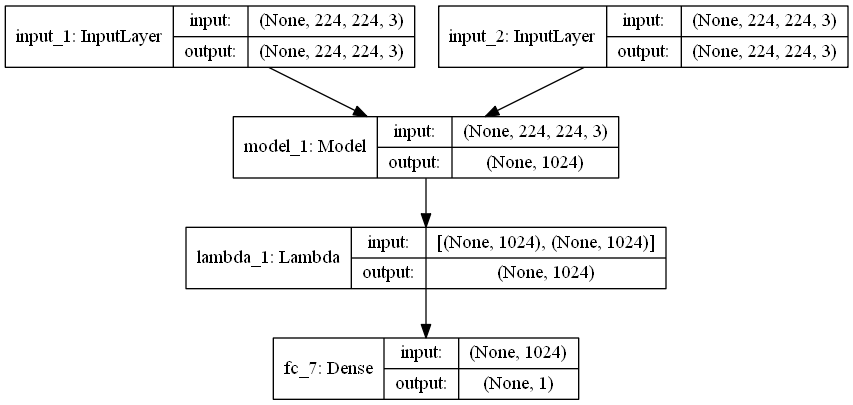

In [15]:
plot_model(model, show_shapes=True, show_layer_names=True)

In [16]:
METRICS = [
        tf.keras.metrics.BinaryAccuracy(),
        tf.keras.metrics.Precision(name="precision"),
        tf.keras.metrics.Recall(name="recall"),
        tf.keras.metrics.AUC(name="AUC"),
        tf.keras.metrics.TruePositives(name="true_positives"),
        tf.keras.metrics.TrueNegatives(name="true_negatives"),
        tf.keras.metrics.FalsePositives(name="false_positives"),
        tf.keras.metrics.FalseNegatives(name="false_negatives"),
        keras.metrics.SensitivityAtSpecificity(0.5, name = "sensitivity"),
        keras.metrics.SpecificityAtSensitivity(0.5, name = "specificity")]
    


#model.compile(loss=contrastive_loss, optimizer=keras.optimizers.Adam(lr=0.00001), metrics=[accuracy])
#model.compile(loss=contrastive_loss, optimizer=keras.optimizers.Adam(lr=0.00001), metrics=METRICS)
model.compile(loss=keras.losses.binary_crossentropy, optimizer=keras.optimizers.Adam(lr=0.001), metrics=METRICS)

Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


In [17]:
history = model.fit([train_X1,train_X2], train_Y,
          batch_size=32, 
          epochs=20,
          verbose=1, validation_split=.20)
          #validation_data=([test_X1,test_X2],test_Y))

model.save('neurowavel_siamese_classification_2class.h5')


Train on 3600 samples, validate on 900 samples
Epoch 1/20
3600/3600 [==============================] - 42s 12ms/step - loss: 0.3921 - binary_accuracy: 0.6392 - precision: 0.6483 - recall: 0.6154 - AUC: 0.7141 - true_positives: 622.8230 - true_negatives: 655.6017 - false_positives: 247.1593 - false_negatives: 298.2743 - sensitivity: 0.9820 - specificity: 0.9763 - val_loss: 0.7549 - val_binary_accuracy: 0.7587 - val_precision: 0.7454 - val_recall: 0.8002 - val_AUC: 0.8652 - val_true_positives: 1659.4482 - val_true_negatives: 1431.0000 - val_false_positives: 576.5862 - val_false_negatives: 412.0000 - val_sensitivity: 0.3957 - val_specificity: 0.3767
Epoch 2/20
3600/3600 [==============================] - 35s 10ms/step - loss: 0.1265 - binary_accuracy: 0.7987 - precision: 0.7733 - recall: 0.8595 - AUC: 0.9017 - true_positives: 2793.3098 - true_negatives: 2286.6018 - false_positives: 798.3275 - false_negatives: 445.6195 - sensitivity: 0.9967 - specificity: 0.9960 - val_loss: 1.3922 - val_b

Epoch 14/20
3600/3600 [==============================] - 35s 10ms/step - loss: 9.6543e-04 - binary_accuracy: 0.9321 - precision: 0.9152 - recall: 0.9558 - AUC: 0.9688 - true_positives: 29465.8145 - true_negatives: 26766.0449 - false_positives: 2730.0000 - false_negatives: 1362.0000 - sensitivity: 1.0000 - specificity: 1.0000 - val_loss: 0.0295 - val_binary_accuracy: 0.9346 - val_precision: 0.9181 - val_recall: 0.9574 - val_AUC: 0.9704 - val_true_positives: 30609.4492 - val_true_negatives: 27877.5859 - val_false_positives: 2730.0000 - val_false_negatives: 1362.0000 - val_sensitivity: 1.0000 - val_specificity: 1.0000
Epoch 15/20
3600/3600 [==============================] - 35s 10ms/step - loss: 6.4927e-04 - binary_accuracy: 0.9369 - precision: 0.9208 - recall: 0.9589 - AUC: 0.9719 - true_positives: 31759.7871 - true_negatives: 28972.0703 - false_positives: 2730.0000 - false_negatives: 1362.0000 - sensitivity: 1.0000 - specificity: 1.0000 - val_loss: 0.0281 - val_binary_accuracy: 0.9390 -

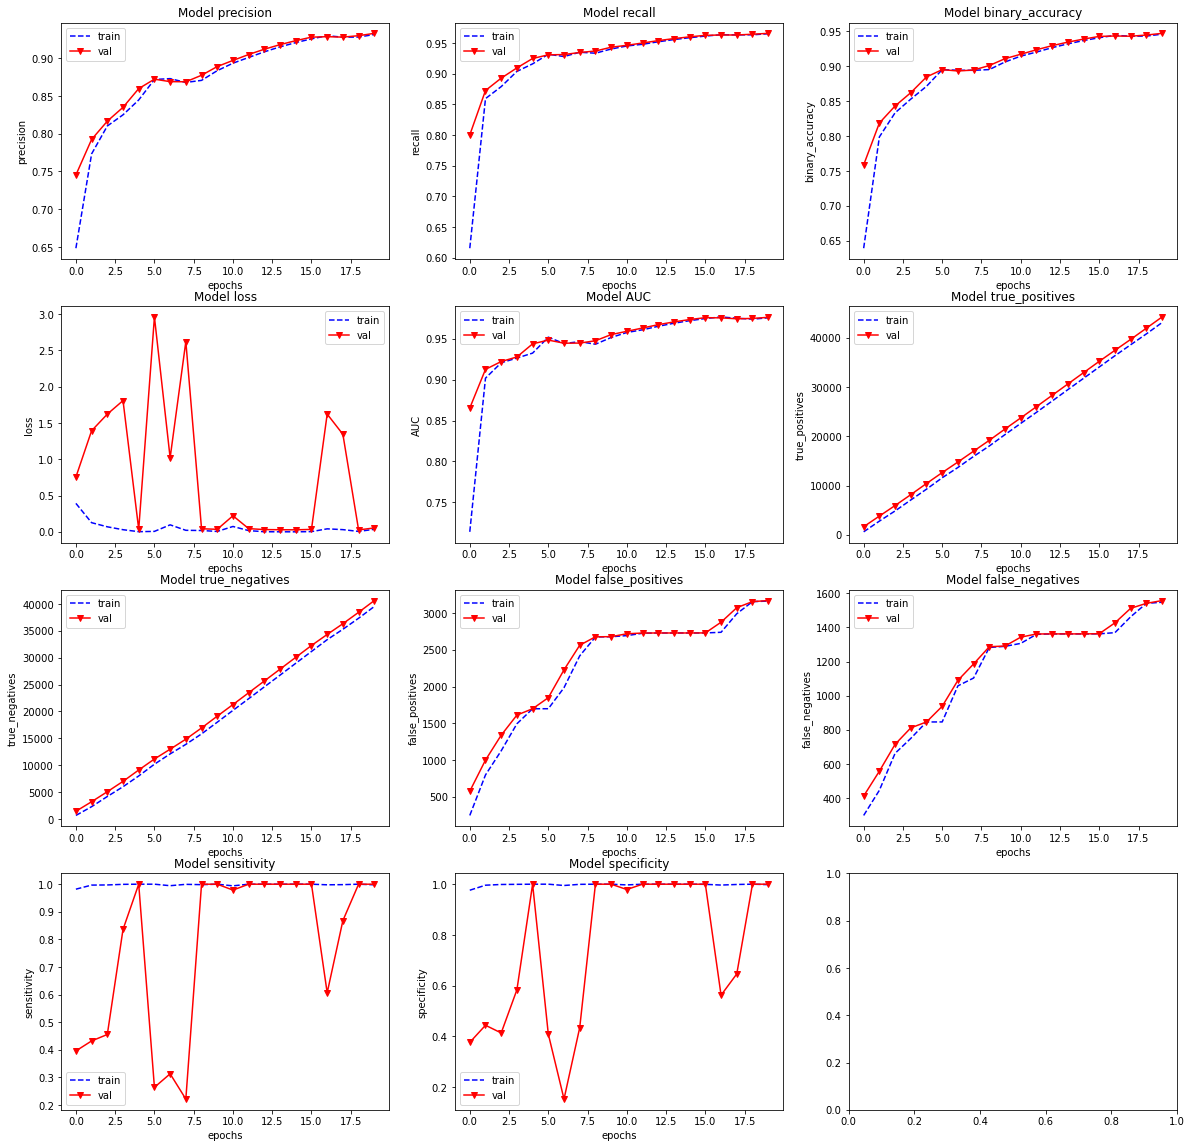

In [18]:
fig, ax = plt.subplots(4, 3, figsize=(20, 20))
ax = ax.ravel()

for i, met in enumerate(["precision", "recall", "binary_accuracy", "loss", "AUC", "true_positives", "true_negatives",
                        "false_positives", "false_negatives", "sensitivity", "specificity"]):
    ax[i].plot(history.history[met], 'b--')
    ax[i].plot(history.history["val_" + met], 'r-v')
    ax[i].set_title("Model {}".format(met))
    ax[i].set_xlabel("epochs")
    ax[i].set_ylabel(met)
    ax[i].legend(["train", "val"])

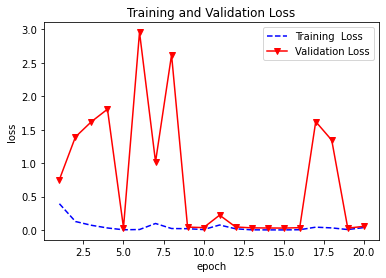

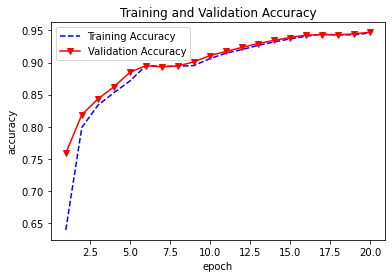

In [19]:
acc = history.history['binary_accuracy']
val_acc = history.history['val_binary_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(acc) + 1)

#Plot Train and Validation Loss
plt.plot(epochs, loss, 'b--', label='Training  Loss')
plt.plot(epochs, val_loss, 'r-v', label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel("epoch")
plt.ylabel("loss")
plt.legend()
plt.show()


#Plot Train and Validation Accuracy
plt.plot(epochs, acc, 'b--', label='Training Accuracy')
plt.plot(epochs, val_acc, 'r-v', label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel("epoch")
plt.ylabel("accuracy")
plt.legend()
plt.show()

In [20]:
metrics = model.evaluate( [test_X1,test_X2],test_Y ) 
print( 'Loss of {} and Accuracy is {} %'.format( metrics[0] , metrics[1] * 100 ) )

541/541 [==============================] - 2s 4ms/step
Loss of 0.0342186597139745 and Accuracy is 94.76026892662048 %


In [21]:
metrics = model.evaluate( [train_X1,train_X2], train_Y ) 
print( 'Loss of {} and Accuracy is {} %'.format( metrics[0] , metrics[1] * 100 ) )

4500/4500 [==============================] - 16s 3ms/step
Loss of 0.044701007948981394 and Accuracy is 94.89779472351074 %


In [22]:
y_pred = model.predict([test_X1,test_X2])
y_pred = (y_pred <= 0.5)

In [23]:
acc = history.history['binary_accuracy']
val_acc = history.history['val_binary_accuracy']
pre = history.history['precision']
val_pre = history.history['val_precision']
rcall = history.history['recall']
val_rcall = history.history['val_recall']
aruc = history.history['AUC']
val_aruc = history.history['val_AUC']
loss = history.history['loss']
val_loss = history.history['val_loss']
true_pos = history.history['true_positives']
true_neg = history.history['true_negatives']
false_pos = history.history['false_positives']
false_neg = history.history['false_negatives']
val_true_pos = history.history['val_true_positives']
val_true_neg = history.history['val_true_negatives']
val_false_pos = history.history['val_false_positives']
val_false_neg = history.history['val_false_negatives']
epochs = range(1, len(acc) + 1)

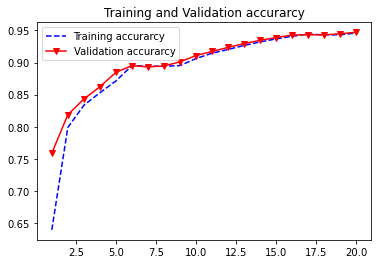

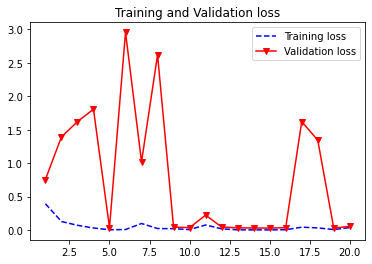

In [24]:

#Train and validation accuracy
plt.plot(epochs, acc, 'b--', label='Training accurarcy')
plt.plot(epochs, val_acc, 'r-v', label='Validation accurarcy')
plt.title('Training and Validation accurarcy')
plt.legend()

plt.figure()
#Train and validation loss
plt.plot(epochs, loss, 'b--', label='Training loss')
plt.plot(epochs, val_loss, 'r-v', label='Validation loss')
plt.title('Training and Validation loss')
plt.legend()
plt.show()


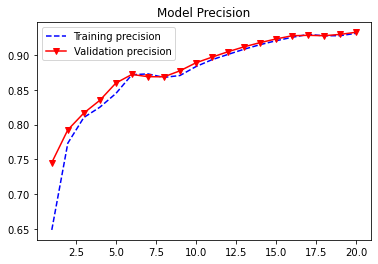

In [25]:
#Train and validation accuracy on Model Precision
plt.plot(epochs, pre, 'b--', label='Training precision')
plt.plot(epochs, val_pre, 'r-v', label='Validation precision')
plt.title('Model Precision')
plt.legend()



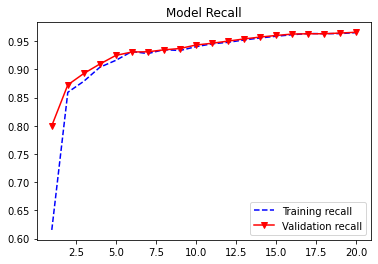

In [26]:
#Train and validation accuracy on Model Recall
plt.plot(epochs, rcall, 'b--', label='Training recall')
plt.plot(epochs, val_rcall, 'r-v', label='Validation recall')
plt.title('Model Recall')
plt.legend()


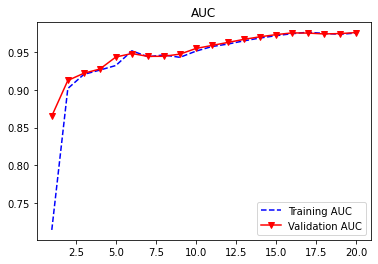

In [27]:
#Train and validation accuracy on Model AUC
plt.plot(epochs, aruc, 'b--', label='Training AUC')
plt.plot(epochs, val_aruc, 'r-v', label='Validation AUC')
plt.title('AUC')
plt.legend()

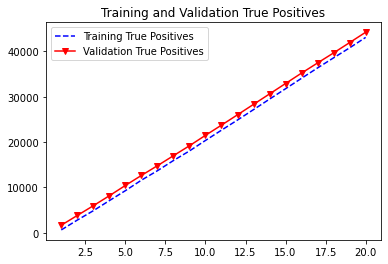

In [28]:
#Train and validation accuracy on True positives
plt.plot(epochs, true_pos, 'b--', label='Training True Positives')
plt.plot(epochs, val_true_pos, 'r-v', label='Validation True Positives')
plt.title('Training and Validation True Positives')
plt.legend()
plt.show()



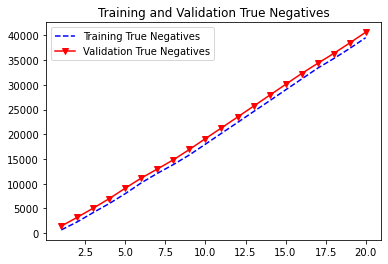

In [29]:
##Train and validation accuracy on True Negatives 
plt.plot(epochs, true_neg, 'b--', label='Training True Negatives')
plt.plot(epochs, val_true_neg, 'r-v', label='Validation True Negatives')
plt.title('Training and Validation True Negatives')
plt.legend()
plt.show()


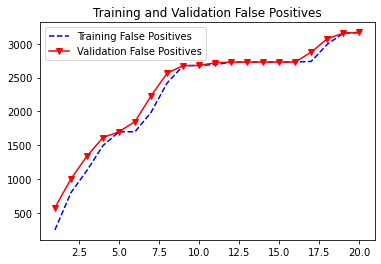

In [30]:
##Train and validation accuracy on False Positives
plt.plot(epochs, false_pos, 'b--', label='Training False Positives')
plt.plot(epochs, val_false_pos, 'r-v', label='Validation False Positives')
plt.title('Training and Validation False Positives')
plt.legend()
plt.show()


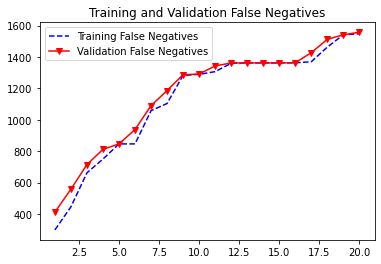

In [31]:
##Train and validation accuracy on False Negatives
plt.plot(epochs, false_neg, 'b--', label='Training False Negatives')
plt.plot(epochs, val_false_neg, 'r-v', label='Validation False Negatives')
plt.title('Training and Validation False Negatives')
plt.legend()
plt.show()

In [32]:
y_pred = model.predict([test_X1,test_X2])
y_pred = (y_pred >= 0.5)

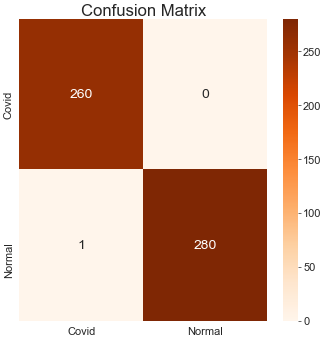

In [33]:
import pandas as pd
from sklearn.metrics import confusion_matrix, accuracy_score
import numpy as np
import warnings
import matplotlib.pyplot as plt
import seaborn as sn
warnings.filterwarnings("ignore")
fig = plt.figure(num = None, figsize=(10, 10), dpi=40, facecolor ='w', edgecolor='k')
cm = confusion_matrix(test_Y, y_pred)
conf_matrix = pd.DataFrame(data = cm, 
                           columns = ['Covid', 'Normal'], 
                           index = ['Covid', 'Normal'])
sn.set(font_scale = 1.8)# for label size
sn.heatmap(conf_matrix, annot = True,fmt='.0f', annot_kws = {"size":25}, cmap="Oranges")#font size
plt.title('Confusion Matrix', fontsize =30)
plt.show()

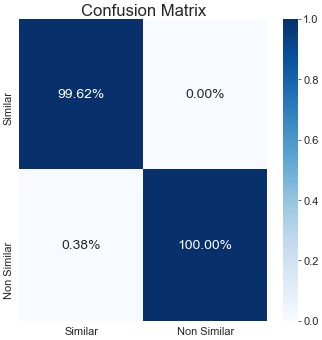

In [34]:
import pandas as pd
from sklearn.metrics import confusion_matrix, accuracy_score
import numpy as np
import warnings
import matplotlib.pyplot as plt
import seaborn as sn
warnings.filterwarnings("ignore")
fig = plt.figure(num = None, figsize=(10, 10), dpi=40, facecolor ='w', edgecolor='k')
cm = confusion_matrix(test_Y, y_pred)
conf_matrix = pd.DataFrame(data = cm, 
                            columns = ['Similar', 'Non Similar'], 
                           index = ['Similar', 'Non Similar'])
sn.set(font_scale = 1.8)# for label size
sn.heatmap(conf_matrix/np.sum(conf_matrix), annot = True,fmt='.2%', annot_kws = {"size":25}, cmap="Blues")#font size
plt.title('Confusion Matrix', fontsize =30)
plt.show()
#conf_matrix

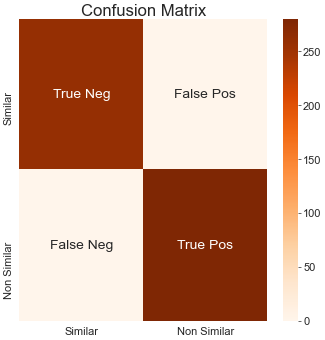

In [35]:
import pandas as pd
from sklearn.metrics import confusion_matrix, accuracy_score
import numpy as np
import warnings
import matplotlib.pyplot as plt
import seaborn as sn
warnings.filterwarnings("ignore")
fig = plt.figure(num = None, figsize=(10, 10), dpi=40, facecolor ='w', edgecolor='k')
cm = confusion_matrix(test_Y, y_pred)

conf_matrix = pd.DataFrame(data = cm, 
                            columns = ['Similar', 'Non Similar'], 
                           index = ['Similar', 'Non Similar'])

labels = ['True Neg','False Pos','False Neg','True Pos']
labels = np.asarray(labels).reshape(2,2)

sn.set(font_scale = 1.8)# for label size
sn.heatmap(conf_matrix, annot =labels, fmt='', annot_kws = {"size":25}, cmap="Oranges")#font size
plt.title('Confusion Matrix', fontsize =30)
plt.show()

<Figure size 400x400 with 0 Axes>

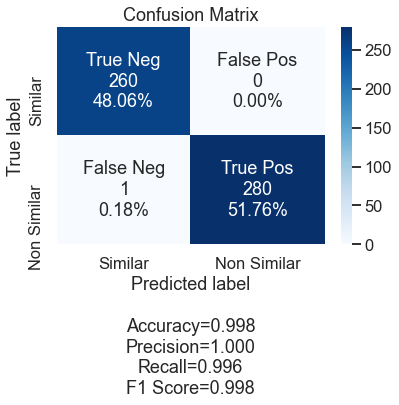

In [36]:
import pandas as pd
from sklearn.metrics import confusion_matrix, accuracy_score
import numpy as np
import warnings
import matplotlib.pyplot as plt
import seaborn as sn

from cf_matrix import make_confusion_matrix
sn.set_context('talk')

warnings.filterwarnings("ignore")
fig = plt.figure(num = None, figsize=(10, 10), dpi=40, facecolor ='w', edgecolor='k')
cm = confusion_matrix(test_Y, y_pred)

conf_matrix = np.array(conf_matrix)


labels = ['True Neg','False Pos','False Neg','True Pos']
categories = ['Similar', 'Non Similar']

make_confusion_matrix(conf_matrix, group_names=labels, categories=categories, cmap='Blues', title='Confusion Matrix')



In [37]:
from sklearn import metrics
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import auc
from sklearn.metrics import roc_auc_score
from sklearn.metrics import average_precision_score

#r = np.flip(sklearn.metrics.confusion_matrix(y_true, y_pred))
r = (confusion_matrix(test_Y, y_pred))
print("Confusion Matrix")
print(r)

#precision = sklearn.metrics.precision_score(y_true=y_true, y_pred=y_pred, pos_label="positive")
precision = precision_score(y_true=test_Y, y_pred=y_pred)
print('precision')
print(precision)

#recall = sklearn.metrics.recall_score(y_true=test_Y, y_pred=y_pred, pos_label="positive")
recall = recall_score(y_true=test_Y, y_pred=y_pred)
print('recall')                      
print(recall)


#recall = sklearn.metrics.recall_score(y_true=test_Y, y_pred=y_pred, pos_label="positive")
roc_auc = roc_auc_score(test_Y, y_pred, average=None)
print('ROC AUC')                      
print(roc_auc)

#average_precision = average_precision_score(test_Y, y_pred)
#print('Average Precision')                      
#print(average_precision)



Confusion Matrix
[[260   0]
 [  1 280]]
precision
1.0
recall
0.99644128113879
ROC AUC
0.998220640569395


In [38]:
#cm = confusion_matrix(testY.argmax(axis=1), predIdxs)
cm = confusion_matrix(test_Y, y_pred)
total = sum(sum(cm))
acc = (cm[0, 0] + cm[1, 1]) / total
sensitivity = cm[0, 0] / (cm[0, 0] + cm[0, 1])
specificity = cm[1, 1] / (cm[0, 1] + cm[1, 1])

# show the confusion matrix, accuracy, sensitivity, and specificity
print('Confusion Matrix')
print(cm)
print("accuracy: {:.4f}".format(acc))
print("sensitivity: {:.4f}".format(sensitivity))
print("specificity: {:.4f}".format(specificity))



Confusion Matrix
[[260   0]
 [  1 280]]
accuracy: 0.9982
sensitivity: 1.0000
specificity: 1.0000


In [39]:
from sklearn.metrics import classification_report
target_names = ['Covid', 'Normal']

print(classification_report(test_Y, y_pred, target_names = target_names ))


              precision    recall  f1-score   support

       Covid       1.00      1.00      1.00       260
      Normal       1.00      1.00      1.00       281

    accuracy                           1.00       541
   macro avg       1.00      1.00      1.00       541
weighted avg       1.00      1.00      1.00       541



In [40]:
from keras import backend as K
import gc

K.clear_session()
gc.collect()

del model

In [41]:
# you will need to install numba using "pip install numba"
from numba import cuda

cuda.select_device(0)
cuda.close()